### For each connecting rod appearing in the image, the vision system should provide the following information:
#### 1. Type of rod (A or B).
#### 2. Position and orientation (modulo pi).
#### 3. Length (L), Width (W), Width at the barycenter (WB).
#### 4. For each hole, position of the centre and diameter size.


Images may contain other objects (i.e. screws and washers) that need not to be analysed by the system (such kind of objects are often referred to in computer vision as “distractors”). Rods can have contact points but do not overlap one to another. The inspection area may be dirty due to the presence of scattered iron powder.

In [1]:
import os
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import collections
from statistics import mean
import random

import math
file_list = ['TESI00.BMP', 'TESI01.BMP', 'TESI12.BMP', 'TESI21.BMP', 'TESI31.BMP', 'Tesi33.bmp',
            'TESI44.BMP', 'TESI47.BMP', 'TESI48.BMP', 'TESI49.BMP', 'TESI50.BMP', 'TESI51.BMP',
            'TESI90.BMP', 'TESI92.BMP', 'TESI98.BMP']
m=0

In [2]:
path = ('ispezione-bielle-immagini')
img_file = file_list[m]
m+=1
src = cv.imread(os.path.join(path, img_file), cv.COLOR_BGR2RGB)

1. Apply a Median filter to remove iron powder and imperfections, which affect results as impulse noise
2. Apply Otsu's thresholding method to binarize the image and obtain invariance to lighting conditions.

Current image:  TESI00.BMP


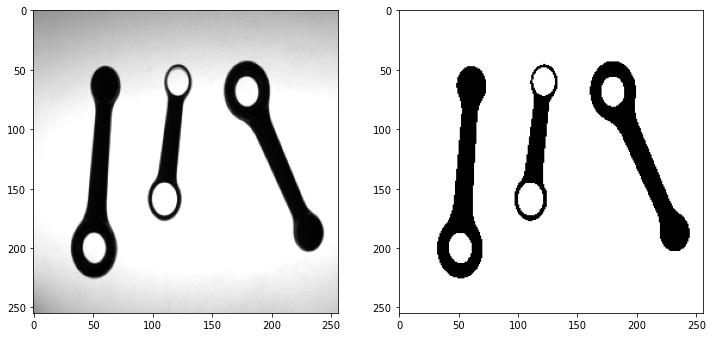

In [3]:
print('Current image: ', img_file)
blur = cv.medianBlur(src,3)
_,dst = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

f, axarr = plt.subplots(1,2, figsize=(12, 12))
axarr[0].imshow(src, cmap='gray')
axarr[1].imshow(dst, cmap='gray')
plt.show()

3 - Find connected components, filtering out distractors by area. Divide rods having contact points.

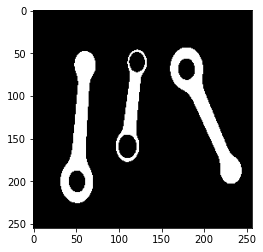

In [4]:
MIN_AREA = 1100
inverted = cv.bitwise_not(dst)

#Create a black background image to store results
img = np.zeros(inverted.shape, dtype="uint8")
blob_x = collections.defaultdict(list)
contact_points_img = 0
j=0

num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(inverted, 8) 
for i in range(1, num_labels):
    area = stats[i, cv.CC_STAT_AREA]
    
    #Filter out object whose area is below a certain threshold
    if(area >= MIN_AREA):
        componentMask = (labels == i).astype("uint8") * 255
        component = componentMask.copy()

        # Look for defects in connected components labeling by using the convex hull 
        contours, hierarchy = cv.findContours(image=component, mode=cv.RETR_EXTERNAL, method=cv.CHAIN_APPROX_NONE)
        cnt = contours[0]
        hull = cv.convexHull(cnt, returnPoints=False)
        defects = cv.convexityDefects(cnt, hull)
        
        # Separate touching rods. The distance between convex hull and intersection point is longer than the others,
        # a threshold is set to find defect points at a longer distance
        contact_points = []

        THRESH_POINTS = 4000
        for n in range(defects.shape[0]):
            s,e,f,d = defects[n,0]
            far = tuple(cnt[f][0])
            if(d > THRESH_POINTS):
                contact_points.append(far)
                
        # Draw a line between couples of points where the defect is detected
        for c in range(len(contact_points)):
            if(c%2==0):
                cv.line(component, contact_points[c], contact_points[c+1], (0, 0, 0), thickness=2, lineType=cv.LINE_AA)
        blob_x['components'].append(component)
                
        contact_points_img = contact_points_img + len(contact_points)
        j+=1
                
#If the blobs had an intersection, repeat connected components labeling after separation
if(contact_points_img !=0):
    filtered_blobs = collections.defaultdict(list)
    for blob in blob_x['components']:
        num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(blob, 8)
        for i in range(1, num_labels):
            area = stats[i, cv.CC_STAT_AREA]
            if(area >= MIN_AREA):
                componentMask = (labels == i).astype("uint8") * 255
                filtered_blobs['components'].append(componentMask)
    final_blobs = filtered_blobs
else:
    final_blobs = blob_x

# Append blobs to the background image
for i in range(len(final_blobs['components'])):
    img = img + final_blobs['components'][i]
plt.imshow(img, cmap='gray')
plt.show()

4 - Compute orientation and information about internal circles

Blob 0 - type A (1 holes)
Coordinates of baricenter: (199, 114)
Orientation major axis: 0.41

Blob 1 - type B (2 holes)
Coordinates of baricenter: (115, 115)
Orientation major axis: 3.03

Blob 2 - type A (1 holes)
Coordinates of baricenter: (54, 147)
Orientation major axis: 3.07



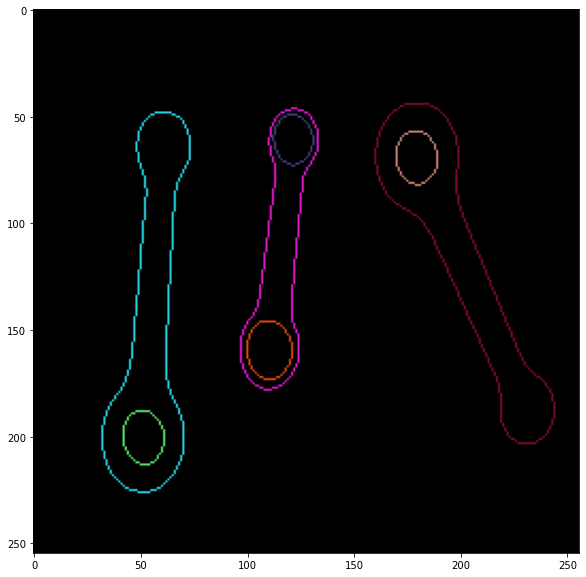

In [5]:
blob_details = collections.defaultdict(list)
circles = collections.defaultdict(list)
contours_voc = collections.defaultdict(list)
drawing = np.zeros((inverted.shape[0], inverted.shape[1], 3), dtype=np.uint8)


for index in range(0, len(final_blobs['components'])):
    blob = final_blobs['components'][index]
    count_holes = 0
    
    # Dilate by a circular structural element to strenghten contours
    if contact_points_img == 0:
        kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2))
        blob = cv.dilate(blob, kernel, iterations=1)      

    # Find internal contours to get information about circles
    contours, hierarchy = cv.findContours(blob, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    for i in range(len(contours)):
        #Circles in a contour have a parent (the blob) but do not have any child:
        if(hierarchy[0][i][2] == -1 and hierarchy[0][i][3] != -1):
            circles[index].append(contours[i])
            count_holes += 1
            
        color = (random.randint(0,256), random.randint(0,256), random.randint(0,256))
        cv.drawContours(drawing, contours, i, color, 1, cv.LINE_8, hierarchy, 0)
    
    # Assign blob type
    if(count_holes > 1):
        type_rod = 'B'
    else:
        type_rod = 'A'
    print(f'Blob {index} - type {type_rod} ({count_holes} holes)')
    
    # Find external contours to get information about the rods
    contours_ext, hierarchy = cv.findContours(image=blob, mode=cv.RETR_EXTERNAL, method=cv.CHAIN_APPROX_NONE)
    for i in range(len(contours_ext)):

        # Get moments to compute baricentre and orientation of the major/minor axis
        mu = cv.moments(contours_ext[i])
        baricentre = (int(mu['m10'] / (mu['m00'] + 1e-5)), int(mu['m01'] / (mu['m00'] + 1e-5)))
        tan_2 = (2 * mu['mu11']) / ( mu['mu20'] -  mu['mu02'])
        orientation_maj = -1/2 * np.arctan(tan_2) 
        orientation_min = -1/2 * np.arctan(tan_2) + math.pi/2
        
        blob_details[index].append(contours_ext[i])
        blob_details[index].append(baricentre)
        blob_details[index].append(mu)
        blob_details[index].append((orientation_maj, orientation_min))
        if(orientation_maj < 0):
            orientation_maj += math.pi
        print('Coordinates of baricenter:', baricentre)
        print(f'Orientation major axis: {orientation_maj:.2f}')

    print()
    

plt.figure(figsize=(10, 10))
plt.imshow(drawing, cmap='gray')
plt.show()

5 - For each hole, compute position of the centre and diameter size.

In [6]:
print('Circle information - centre and radius')
print()

for k in circles.keys():
    for cont in circles[k]:
        rad = []
        # Compute moments to get the centre of the circle; 
        mu = cv.moments(cont)
        bar = (int(mu['m10'] / (mu['m00'] + 1e-5)), int(mu['m01'] / (mu['m00'] + 1e-5)))
        # Compute the radius as the average distance between the contour and the centre
        if((bar[0] != 0) and (bar[1] != 0)):
            for p in cont:
                distance = math.sqrt((math.pow((bar[0] - p[0][0]),2))+(math.pow((bar[1] - p[0][1]),2)))
                rad.append(distance)
            radius = mean(rad)
            print(f'Blob {k}: centre {bar}, radius {radius:.2f}, diameter {2*radius:.2f}')

Circle information - centre and radius

Blob 0: centre (179, 69), radius 11.24, diameter 22.48
Blob 1: centre (110, 159), radius 12.14, diameter 24.29
Blob 1: centre (121, 60), radius 10.54, diameter 21.09
Blob 2: centre (51, 200), radius 11.17, diameter 22.34


6 - Compute image moments to get the oriented enclosing rectangle and retrieve L and W of each rod

In [7]:
#Implementation of the algorithm from slide 46 of "Blob Analysis"

def compute_oriented_mer(aMA, bMA, cMA, aMI, bMI, cMI, cont):
    dMAmin=100000
    dMAmax=-100000
    dMImin=100000
    dMImax=-100000
    normMA = math.sqrt(math.pow(aMA,2)+math.pow(bMA,2))
    normMI = math.sqrt(math.pow(aMI,2)+math.pow(bMI,2))
    for e in cont:
        j = e[0][0]
        i = e[0][1]
        dMA = (aMA*j+bMA*i+cMA)/normMA
        dMI = (aMI*j+bMI*i+cMI)/normMI
        if(dMA < dMAmin):
            dMAmin = dMA
            C1 = (j,i)
        if(dMA > dMAmax):
            dMAmax = dMA
            C2 = (j,i)
        if(dMI < dMImin):
            dMImin = dMI
            C3 = (j,i)
        if(dMI > dMImax):
            dMImax = dMI
            C4 = (j,i)
    return C1, C2, C3, C4


In [8]:
def get_vertexes(C1, C2, C3, C4, aMA, bMA, aMI, bMI):
    j1, i1 = C1[0], C1[1]
    j2, i2 = C2[0], C2[1]
    j3, i3 = C3[0], C3[1]
    j4, i4 = C4[0], C4[1]

    cl1 = -(aMA*j1 + bMA*i1)
    cl2 = -(aMA*j2 + bMA*i2)
    cw1 = -(aMI*j3 + bMI*i3)
    cw2 = -(aMI*j4 + bMI*i4)
    
    v1 = (int((bMA*cw1 - bMI*cl1)/(aMA*bMI - bMA*aMI)),int((aMI*cl1 - aMA*cw1)/(aMA*bMI - bMA*aMI)))
    v2 = (int((bMA*cw2 - bMI*cl1)/(aMA*bMI - bMA*aMI)),int((aMI*cl1 - aMA*cw2)/(aMA*bMI - bMA*aMI)))
    v3 = (int((bMA*cw1 - bMI*cl2)/(aMA*bMI - bMA*aMI)),int((aMI*cl2 - aMA*cw1)/(aMA*bMI - bMA*aMI)))
    v4 = (int((bMA*cw2 - bMI*cl2)/(aMA*bMI - bMA*aMI)),int((aMI*cl2 - aMA*cw2)/(aMA*bMI - bMA*aMI)))
    return v1,v2,v3,v4

Blob 0 - lenght 171.09, width 41.63, width at barycentre 15.23
Blob 1 - lenght 132.85, width 28.16, width at barycentre 12.65
Blob 2 - lenght 178.47, width 39.12, width at barycentre 14.00


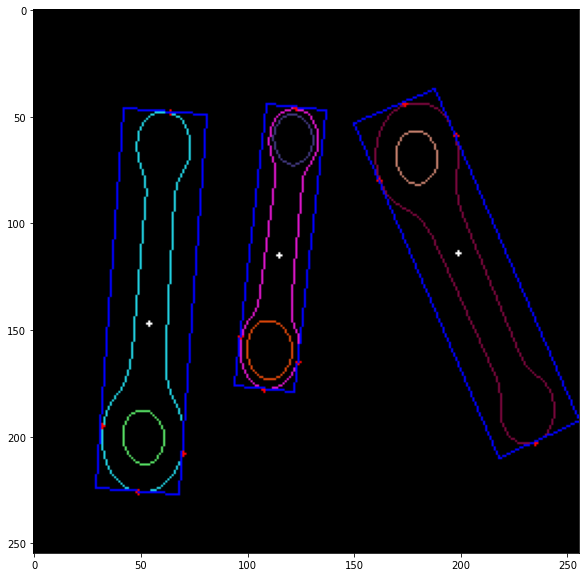

In [9]:
#blob_details contains a list with contour - baricentre - moments - (orientation_maj, orientation_min)
img_oer = drawing.copy()

for b in blob_details.keys():
    blob_contour = blob_details[b][0]
    blob_barycentre = blob_details[b][1]
    blob_moments = blob_details[b][2]
    blob_orientation = blob_details[b][3]
    
    cv.circle(img_oer, (blob_barycentre), radius=0, color=(255, 255, 255), thickness=2)

    
    # Compute alpha and beta from the orientation of the major axis
    alpha = -math.sin(blob_orientation[0])
    beta = math.cos(blob_orientation[0])
    
    # Compute the parameters for the equation of the major and minor axis
    aMA = alpha
    bMA = -beta
    cMA = beta*blob_barycentre[1] - alpha*blob_barycentre[0]
    
    aMI = beta
    bMI = alpha
    cMI = -beta*blob_barycentre[0] - alpha*blob_barycentre[1]
    
    C1, C2, C3, C4 = compute_oriented_mer(aMA, bMA, cMA, aMI, bMI, cMI, blob_contour)

    cv.circle(img_oer, C1, radius=0, color=(255, 0, 0), thickness=2)
    cv.circle(img_oer, C2, radius=0, color=(255, 0, 0), thickness=2)
    cv.circle(img_oer, C3, radius=0, color=(255, 0, 0), thickness=2)
    cv.circle(img_oer, C4, radius=0, color=(255, 0, 0), thickness=2)
    
    # Find vertexes of the oriented enclosing rectangle
    v1, v2, v3, v4 = get_vertexes(C1, C2, C3, C4, aMA, bMA, aMI, bMI)

    cv.line(img_oer, v1, v3, (0, 0, 255), 1)
    cv.line(img_oer, v1, v2, (0, 0, 255), 1)
    cv.line(img_oer, v2, v4, (0, 0, 255), 1)
    cv.line(img_oer, v4, v3, (0, 0, 255), 1)

    # Compute length and width from the OER
    L = math.sqrt((math.pow((v1[0]-v2[0]),2))+(math.pow((v1[1]-v2[1]),2)))
    W = math.sqrt((math.pow((v1[0]-v3[0]),2))+(math.pow((v1[1]-v3[1]),2)))
    if(W > L):
        point1 = v1
        point2 = v2
    else:
        point1 = v1
        point2 = v3

    # Compute width at the barycentre as the minimum distance between the barycentre and the contour
    distances = []
    for e in blob_contour:
        j = e[0][0]
        i = e[0][1]
        distance = math.sqrt((math.pow((blob_barycentre[0] - j),2))+(math.pow((blob_barycentre[1] - i),2)))
        distances.append(distance)
    wb = 2 * np.min(distances)

    print(f'Blob {b} - lenght {max(L,W):.2f}, width {min(L,W):.2f}, width at barycentre {wb:.2f}')
    
plt.figure(figsize=(10, 10))
plt.imshow(img_oer, cmap='gray')
plt.show()